In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tphate
import networkx as nx
import scipy
from numpy import linalg as LA
import scprep

In [2]:
def lazy_random_walk(adj):

    P_array = []
    d = adj.sum(0)
    P_t = adj/d
    P_t[np.isnan(P_t)] = 0
    P = 1/2*(np.identity(P_t.shape[0])+P_t)

    return P

def graph_wavelet(P):

    psi = []
    for d1 in [1,2,4,8,16, 32]:
        W_d1 = LA.matrix_power(P,d1) - LA.matrix_power(P,2*d1)
        psi.append(W_d1)

    return psi

def zero_order_feature(A,ro):

    F0 = np.matmul(LA.matrix_power(A,16),ro)

    return F0

def first_order_feature(A,u,ax):

    F1 = np.matmul(LA.matrix_power(A,16),np.abs(u))
    F1 = np.concatenate(F1,ax)

    return F1

def second_order_feature(A,W,u,ax):

    u1 = np.einsum('ij,ajt ->ait',W[1],u[0:1])
    for i in range(2,len(W)):
        u1 = np.concatenate((u1,np.einsum('ij,ajt ->ait',W[i],u[0:i])),0)
    u1 = np.abs(u1)
    F2 = np.matmul(LA.matrix_power(A,16),u1)
    F2 = np.concatenate(F2,ax)
    
    return F2

def generate_timepoint_feature(adj,ro):

    P = lazy_random_walk(adj)
    
    W = graph_wavelet(P)
    u = np.abs(np.matmul(W,ro))
    
    F0 = zero_order_feature(P,ro)
    F1 = first_order_feature(P,u,0)
    F2 = second_order_feature(P,W,u,0)
    F = np.concatenate((F0,F1),axis=0)
    F = np.concatenate((F,F2),axis=0)

    return F

def generate_celluar_feature(adj,ro):

    P = lazy_random_walk(adj)
    W = graph_wavelet(P)
    u = np.abs(np.matmul(W,ro))
    
    F0 = zero_order_feature(P,ro)
    F1 = first_order_feature(P,u,1)
    F2 = second_order_feature(P,W,u,1)
    F = np.concatenate((F0,F1),axis=1)
    F = np.concatenate((F,F2),axis=1)
    
    return F

In [3]:
def fit_circle_2d(x, y, w=[]):
    
    A = np.array([x, y, np.ones(len(x))]).T
    b = x**2 + y**2
    
    # Modify A,b for weighted least squares
    if len(w) == len(x):
        W = np.diag(w)
        A = np.dot(W,A)
        b = np.dot(W,b)
    
    # Solve by method of least squares
    c = np.linalg.lstsq(A,b,rcond=None)[0]
    
    # Get circle parameters from solution c
    xc = c[0]/2
    yc = c[1]/2
    r = np.sqrt(c[2] + xc**2 + yc**2)
    return xc, yc, r

def rodrigues_rot(P, n0, n1):
    
    # If P is only 1d array (coords of single point), fix it to be matrix
    if P.ndim == 1:
        P = P[newaxis,:]
    
    # Get vector of rotation k and angle theta
    n0 = n0/np.linalg.norm(n0)
    n1 = n1/np.linalg.norm(n1)
    k = np.cross(n0,n1)
    k = k/np.linalg.norm(k)
    theta = np.arccos(np.dot(n0,n1))
    
    # Compute rotated points
    P_rot = np.zeros((len(P),3))
    for i in range(len(P)):
        P_rot[i] = P[i]*np.cos(theta) + np.cross(k,P[i])*np.sin(theta) + k*np.dot(k,P[i])*(1-np.cos(theta))

    return P_rot

def angle_between(u, v, n=None):
    
    if n is None:
        return np.arctan2(np.linalg.norm(np.cross(u,v)), np.dot(u,v))
    else:
        return np.arctan2(np.dot(n,np.cross(u,v)), np.dot(u,v))
    
def compute_curvature(nbd, traj, num_pts):

    kappa = []

    for pt_idx in range(0, num_pts):

        P = traj[max(0, pt_idx-nbd):min(num_pts, pt_idx+nbd),:]
        P_mean = P.mean(axis=0)
        P_centered = P - P_mean
        U,s,V = np.linalg.svd(P_centered)
        normal = V[2,:]
        d = -np.dot(P_mean, normal) 
        P_xy = rodrigues_rot(P_centered, normal, [0,0,1])
        xc, yc, r = fit_circle_2d(P_xy[:,0], P_xy[:,1])
        kappa.append(1.0/r)
    
    return np.array(kappa)

# ROI = 256

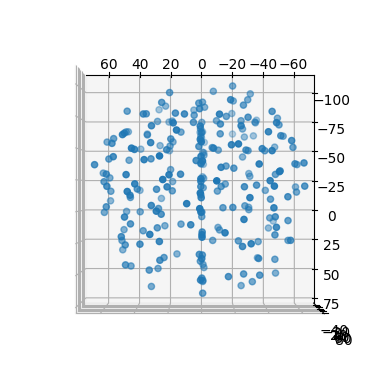

In [9]:
mat_data = np.load('data/diffumo_signal_ROI256.npy')
coords = np.load('data/diffumo_coord_ROI256.npy')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:,0], coords[:, 1], coords[:, 2], marker='o') 
ax.view_init(90, 90)

In [10]:
mat_data.shape

(2, 420, 256)

In [11]:
from nilearn import datasets

# haxby dataset to have EPI images and masks
haxby_dataset = datasets.fetch_haxby()

# print basic information on the dataset
print(
    "First subject anatomical nifti image (3D) is "
    f"at: {haxby_dataset.anat[0]}"
)
print(
    "First subject functional nifti image (4D) is "
    f"at: {haxby_dataset.func[0]}"
)

haxby_anat_filename = haxby_dataset.anat[0]
haxby_mask_filename = haxby_dataset.mask_vt[0]
haxby_func_filename = haxby_dataset.func[0]

# one motor activation map
stat_img = datasets.load_sample_motor_activation_image()


Dataset created in /home/yz2472/nilearn_data/haxby2001



 ...done. (0 seconds, 0 min)


 ...done. (2 seconds, 0 min)


Downloaded 243433472 of 291168628 bytes (83.6%,    0.6s remaining) ...done. (4 seconds, 0 min)
Extracting data from /home/yz2472/nilearn_data/haxby2001/def37a305edfda829916fa14c9ea08f8/subj2-2010.01.14.tar.gz...

First subject anatomical nifti image (3D) is at: /home/yz2472/nilearn_data/haxby2001/subj2/anat.nii.gz
First subject functional nifti image (4D) is at: /home/yz2472/nilearn_data/haxby2001/subj2/bold.nii.gz


.. done.


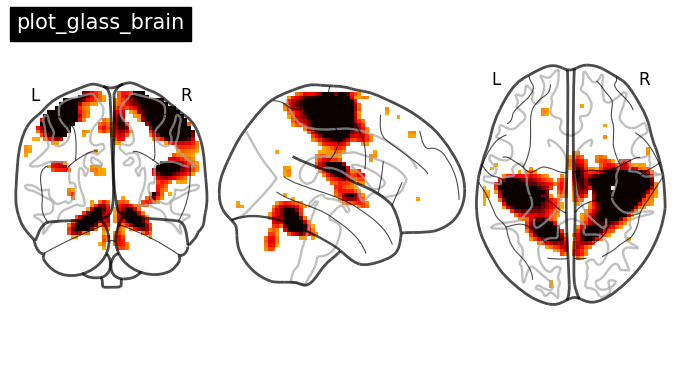

In [13]:
plotting.plot_glass_brain(stat_img, title="plot_glass_brain", threshold=3)

In [16]:
import nibabel as nib
from nilearn import plotting, image

In [17]:
mat_data.shape

(2, 420, 256)

In [21]:
signal = mat_data[0, 1,:]

In [22]:
signal.shape

(256,)

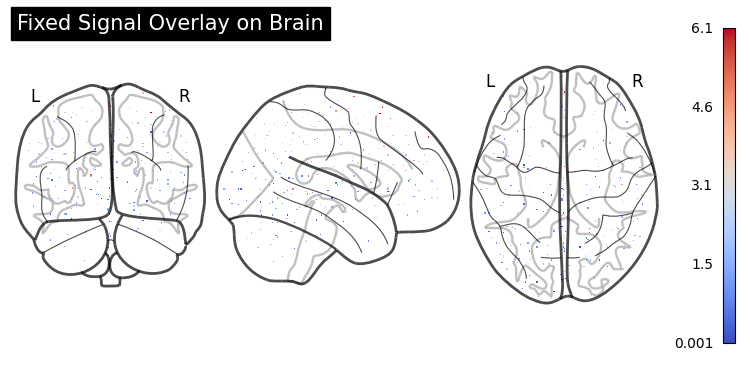

In [44]:
from nilearn.image import load_img
from nilearn.datasets import fetch_icbm152_2009

# Fetch the MNI152 template
mni_template = fetch_icbm152_2009()['t1']  # Path to MNI152 T1 template
mni_img = load_img(mni_template)

# Get the affine matrix of the MNI template
affine = mni_img.affine

# Initialize an empty brain volume
volume_shape = mni_img.shape
brain_volume = np.zeros(volume_shape)



# Map MNI coordinates to voxel space using the affine matrix
coords_homogeneous = np.column_stack([coords, np.ones(len(coords))])  # Add homogeneous 1
voxel_coords = np.round(np.linalg.inv(affine) @ coords_homogeneous.T).astype(int).T[:, :3]

# Populate the brain volume with signal values
for idx, (i, j, k) in enumerate(voxel_coords):
    if 0 <= i < volume_shape[0] and 0 <= j < volume_shape[1] and 0 <= k < volume_shape[2]:
        brain_volume[i, j, k] = signal[idx]

# Convert the volume to a NIfTI image
stat_img = nib.Nifti1Image(brain_volume, affine)

# Save and plot the image
nib.save(stat_img, 'stat_img_fixed.nii.gz')
plotting.plot_glass_brain(stat_img, title="Fixed Signal Overlay on Brain", colorbar=True, cmap="coolwarm", threshold=0.001)
plotting.show()


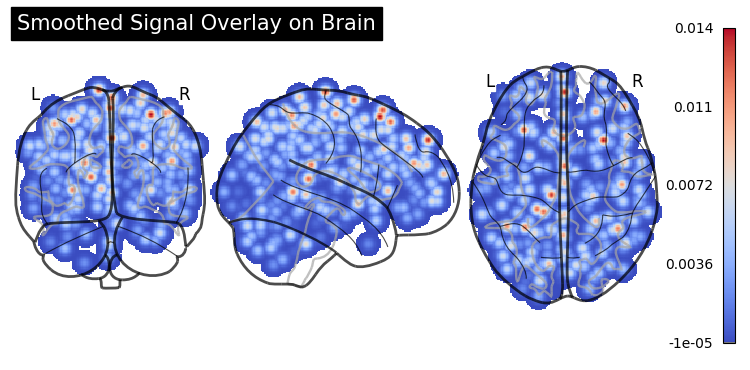

In [48]:
from scipy.ndimage import gaussian_filter

smoothed_volume = gaussian_filter(brain_volume, sigma=3)

# Create a smoothed stat image
smoothed_stat_img = nib.Nifti1Image(smoothed_volume, affine)

# Save and visualize
nib.save(smoothed_stat_img, 'smoothed_stat_img.nii.gz')
plotting.plot_glass_brain(
    smoothed_stat_img, title="Smoothed Signal Overlay on Brain", colorbar=True, cmap="coolwarm"
)
plotting.show()